#Installing/Installing Necessary Libraries

In [1]:
!pip install protobuf==3.20.*

In [2]:
!pip install -q tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q einops

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import collections
import time
import string
import re
import einops
from tqdm.auto import tqdm
from PIL import Image
import nltk
from nltk.util import ngrams

import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow_datasets as tfds

In [67]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Loading the Data

In [68]:
path = pathlib.Path('flickr8k')

tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                        cache_dir = '.',
                        cache_subdir = path,
                        extract = True)

tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                        cache_dir = '.',
                        cache_subdir = path,
                        extract = True)

In [180]:
path = pathlib.Path('flickr8k')

# Cleaning The Data and bringing to presentable format
captions = (path/'Flickr8k.token.txt').read_text().splitlines()
captions = [cap.split('\t') for cap in captions]
captions = [(img_path.split('#')[0], cap) for (img_path, cap) in captions]

# Making Dictionary Image:Caption
cap_dict = collections.defaultdict(list)
for img_path, cap in captions:
    cap_dict[img_path].append(cap)

# Splitting the data into Train/Test
train_imgs_path = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
test_imgs_path = (path/'Flickr_8k.testImages.txt').read_text().splitlines()

train_caps = [(str(path/'Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in train_imgs_path]
test_caps = [(str(path/'Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in test_imgs_path]

train_raw = tf.data.experimental.from_list(train_caps)
test_raw = tf.data.experimental.from_list(test_caps)


#Data Visualization

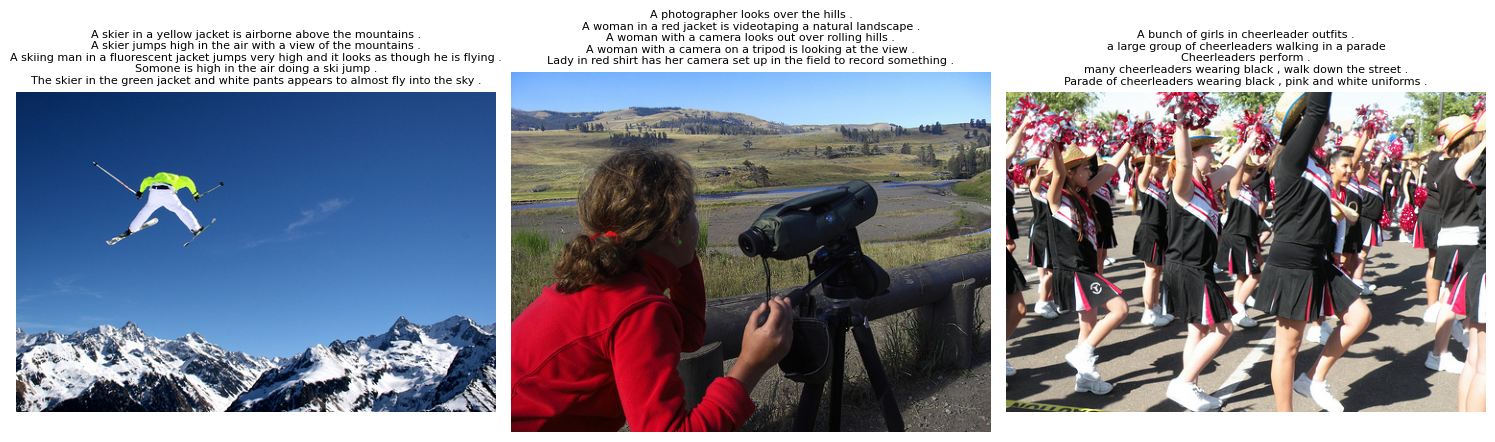

In [183]:
import matplotlib.pyplot as plt
from PIL import Image

# Display a few examples of images with captions starting from a specific index
def show_image_with_captions(image_paths_and_captions, start_index=0, num_examples=3):
    plt.figure(figsize=(15, 18))

    # Get the subset of examples starting from start_index
    for i, (img_path, captions) in enumerate(image_paths_and_captions[start_index:start_index+num_examples]):
        # Open the image
        image = Image.open(img_path)
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(image)
        plt.axis('off')
        # Display captions
        plt.title("\n".join(captions), fontsize=8)

    plt.tight_layout()
    plt.show()

# Call the function with a starting index and number of examples
show_image_with_captions(train_caps, start_index=9, num_examples=3)  # Example: starting from image 5


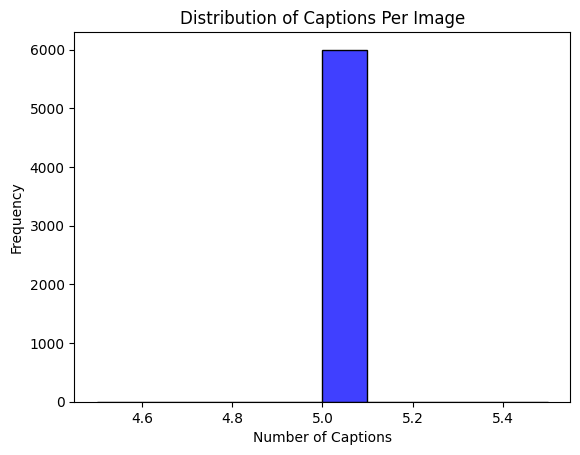

In [184]:
import seaborn as sns
import pandas as pd

# Count the number of captions per image
captions_per_image = [len(captions) for _, captions in train_caps]

# Plot the distribution of captions per image
sns.histplot(captions_per_image, kde=False, bins=10, color='blue')
plt.title("Distribution of Captions Per Image")
plt.xlabel("Number of Captions")
plt.ylabel("Frequency")
plt.show()


<ipython-input-185-9172cfe0259a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=word_freq_df, palette="viridis")


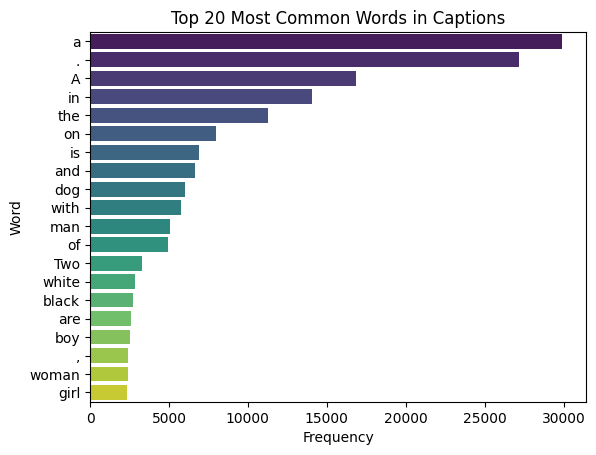

In [185]:
from collections import Counter
import itertools

# Flatten all captions into a single list of words
all_captions = list(itertools.chain(*[captions for _, captions in train_caps]))
all_words = list(itertools.chain(*[caption.split() for caption in all_captions]))

# Count word frequencies
word_counts = Counter(all_words)

# Get the top 20 most common words
common_words = word_counts.most_common(20)

# Plot word frequency
word_freq_df = pd.DataFrame(common_words, columns=["Word", "Frequency"])
sns.barplot(x="Frequency", y="Word", data=word_freq_df, palette="viridis")
plt.title("Top 20 Most Common Words in Captions")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()


#Preprocess & Feature Extraction on Images

In [71]:
image_shape = (224, 224, 3)
feature_extractor = tf.keras.applications.MobileNetV3Small(input_shape = image_shape, include_preprocessing = True, include_top = False)
feature_extractor.trainable = False

In [72]:
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, image_shape[:-1])
    return img

In [73]:
# Test
img = load_img(img_path.numpy().decode('utf-8'))
print(img.shape)
print(feature_extractor(img[tf.newaxis, ...]).shape)

(224, 224, 3)
(1, 7, 7, 576)


#Preprocess & Feature Extraction on Captions

In [74]:
def standardize(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, f'[{re.escape(string.punctuation)}]', '')
    text = tf.strings.join(['[START]',text,'[END]'], separator = ' ')
    return text

In [75]:
# Test
standardize('A black dog is running after a white dog in the snow .')

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] a black dog is running after a white dog in the snow  [END]'>

In [76]:
vocab_size = 5000
vectorizer = tf.keras.layers.TextVectorization(max_tokens = vocab_size,
                                               standardize = standardize,
                                               ragged = True)

vectorizer.adapt(train_raw.map(lambda img_path, cap: cap).unbatch().batch(1024))

In [77]:
print(vectorizer.get_vocabulary()[:10])

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']


In [78]:
text_to_id_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '')
id_to_text_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '', invert = True)

In [79]:
def id_to_text(token_ids, reserved_tokens = ['', '[UNK]', '[START]', '[END]']):
    words = id_to_text_vectorizer(token_ids)
    bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != '[UNK]']
    bad_tokens_re = '|'.join(bad_tokens)
    bad_mask = tf.strings.regex_full_match(words, bad_tokens_re)
    words = tf.ragged.boolean_mask(words, ~bad_mask)

    return tf.strings.reduce_join(words, axis = -1, separator = ' ')

def serialize_data(images, captions):
    captions_shape = einops.parse_shape(captions, 'b c')
    captions = einops.rearrange(captions, 'b c -> (b c)')
    images = einops.repeat(images, 'b ...  -> (b c) ...', c = captions_shape['c'])
    return images, captions

In [80]:
for img, cap in train_raw.batch(1024).take(1):
    break

print(img.shape)
print(cap.shape)
img_serialize, cap_serialize = serialize_data(img, cap)
print(img_serialize.shape, cap_serialize.shape)

(1024,)
(1024, 5)
(5120,) (5120,)


#Dataset Preparation

In [81]:
def prepare_batch(img, cap):
    cap_tokenized = vectorizer(cap)
    cap_tokenized_in = cap_tokenized[:, :-1]
    cap_tokenized_out = cap_tokenized[:, 1:]

    return (img, cap_tokenized_in.to_tensor()), cap_tokenized_out.to_tensor()

In [82]:
def save_dataset(raw_ds, file_path, image_feature_extractor, vectorizer, shards = 20, batch_size = 64):
    raw_ds = (raw_ds
              .map(lambda img_path, cap: (load_img(img_path), cap), tf.data.AUTOTUNE)
              .batch(batch_size))

    def gen():
        for (img, cap) in tqdm(raw_ds):
            img_features = image_feature_extractor(img)
            img_features, cap = serialize_data(img_features, cap)

            yield img_features, cap

    ds = tf.data.Dataset.from_generator(gen,
                                        output_signature = (
                                            tf.TensorSpec(shape = image_feature_extractor.output_shape),
                                            tf.TensorSpec(shape = (None,), dtype = tf.string)
                                        ))

    ds = (ds
          .map(prepare_batch, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(1000))

    def shard_func(i, data):
        return i % shards

    ds.enumerate().save(file_path, shard_func = shard_func)

In [83]:
%%time
save_dataset(train_raw, 'train_cache', feature_extractor, vectorizer)
save_dataset(test_raw, 'test_cache', feature_extractor, vectorizer)

  0%|          | 0/94 [00:01<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 56.7 s, sys: 9.65 s, total: 1min 6s
Wall time: 59.3 s


In [84]:
def load_dataset(file_path, batch_size = 64, cycle_length = 2):
    def reader_func(ds):
        ds = ds.shuffle(1000)
        return ds.interleave(lambda x: x, cycle_length = cycle_length)

    def drop_index(i, x):
        return x

    ds = tf.data.Dataset.load(file_path, reader_func = reader_func)

    ds = (ds
          .map(drop_index)
          .shuffle(1000)
          .padded_batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))
    return ds

In [85]:
batch_size = 64
train_ds = load_dataset('train_cache', batch_size)
test_ds = load_dataset('test_cache', batch_size)

#Positional Encoding

In [88]:
def positional_encoding(length, depth):
    pos = tf.cast(tf.range(length)[:, tf.newaxis], tf.float32)
    dep = tf.cast(tf.range(depth)[tf.newaxis, :], tf.float32)
    dep = ((dep // 2)*2)/tf.cast(depth, tf.float32)

    angle_rates = 1 / (10000**dep)
    angle_rads = pos*angle_rates

    out = tf.Variable(tf.zeros((length, depth)))
    out[:, 0::2].assign(tf.math.sin(angle_rads[:, 0::2]))
    out[:, 1::2].assign(tf.math.cos(angle_rads[:, 1::2]))

    return out[tf.newaxis, ...]

In [89]:
sample_enc = positional_encoding(length = 2048, depth = 512)[0]

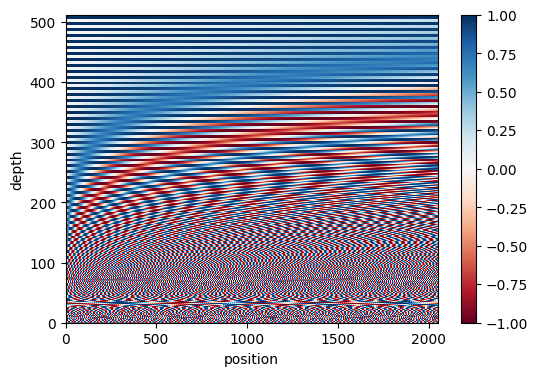

In [90]:
plt.figure(figsize = (6, 4))
plt.pcolormesh(tf.transpose(sample_enc), cmap = 'RdBu')
plt.xlabel('position')
plt.ylabel('depth')
plt.colorbar()
plt.show();

In [92]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero = True)
        self.pos_enc = positional_encoding(length = 2048, depth = d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x_emb = self.embedding(x)
        x_pos_enc = self.pos_enc[:, :length, :]

        x_emb *= tf.cast(self.d_model, tf.float32)
        x_emb += x_pos_enc

        return x_emb

In [93]:
sample_pos_emb = PositionalEmbedding(vocab_size, d_model = 512)
cap_emb = sample_pos_emb(cap)
print(cap_emb.shape)

(64, 34, 512)


#Attention Mechanisms


In [94]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

In [95]:
class CausalAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query = x,
                               key = x,
                               value = x,
                               use_causal_mask = True)

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [96]:
sample_csa = CausalAttention(num_heads = 8, key_dim = 512)
sample_csa_out = sample_csa(cap_emb)
print(sample_csa_out.shape)

(64, 34, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'causal_attention_16' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [106]:
print(f"Image features (img_): {img_.shape}")  # Should be (batch_size, num_patches, feature_dim)
print(f"Sequence features (sample_csa_out): {sample_csa_out.shape}")  # Should be (batch_size, sequence_length, feature_dim)


Image features (img_): (64, 49, 576)
Sequence features (sample_csa_out): (64, 34, 512)


In [107]:
class CrossAttention(BaseAttention):
    def call(self, context, x):
        attn_out, attn_scores = self.mha(query = x,
                                         key = context,
                                         value = context,
                                         return_attention_scores = True)

        self.last_attention_scores = attn_scores

        x = self.add([x, attn_out])
        x = self.layernorm(x)
        return x

In [108]:
project_img = tf.keras.layers.Dense(512)(img_)
print(f"Projected Image shape: {project_img.shape}")  # Should be (64, 49, 512)

# Define and test CrossAttention
sample_ca = CrossAttention(num_heads=8, key_dim=512)
sample_ca_out = sample_ca(context=project_img, x=sample_csa_out)
print(f"CrossAttention output shape: {sample_ca_out.shape}")  # Expected: (64, 34, 512)


Projected Image shape: (64, 49, 512)
CrossAttention output shape: (64, 34, 512)


#Model Components

In [109]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation = 'relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(rate = dropout_rate)
        ])

        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        return x

In [110]:
sample_ffn = FeedForward(d_model = 512, dff = 2048)
sample_ffn_out = sample_ffn(sample_ca_out)
print(sample_ffn_out.shape)

(64, 34, 512)


In [113]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, num_heads, dropout_rate=0.1):
        super().__init__()
        self.causal_attention = CausalAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )
        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )
        self.context_projection = tf.keras.layers.Dense(d_model)  # Projection layer
        self.ffn = FeedForward(
            d_model=d_model,
            dff=dff,
            dropout_rate=dropout_rate
        )
        self.last_attention_scores = None

    def call(self, context, x):
        # Project context to match x's feature dimension
        context = self.context_projection(context)

        x = self.causal_attention(x)
        x = self.cross_attention(context=context, x=x)
        x = self.ffn(x)
        self.last_attention_scores = self.cross_attention.last_attention_scores

        return x


In [114]:
sample_decoder_layer = DecoderLayer(d_model = 512, dff = 2048, num_heads = 8, dropout_rate = 0.2)
sample_decoder_layer_out = sample_decoder_layer(context = img_, x = cap_emb)
print(sample_decoder_layer_out.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'causal_attention_18' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'sequential_18' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 34, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'feed_forward_18' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [115]:
class OutputLayer(tf.keras.layers.Layer):
    def __init__(self, vocab, bad_tokens = ('', '[UNK]', '[START]')):
        super().__init__()
        self.vocab = vocab
        self.bad_tokens = bad_tokens
        self.bias = 0
        self.dense_layer = tf.keras.layers.Dense(len(vocab), activation = tf.nn.log_softmax)

    def adapt(self, cap_ds):
        word_idx = {word : idx for idx, word in enumerate(self.vocab)}
        counts = collections.Counter()
        for tokens in cap_ds:
            counts.update(tokens.numpy().flatten())

        counts_arr = np.zeros((len(self.vocab), ))
        for token_id, cnt in counts.items():
            counts_arr[token_id] = cnt

        bad_indices = np.array([word_idx[word] for word in self.bad_tokens])
        counts_arr[bad_indices] = 0

        counts_prob = counts_arr / counts_arr.sum()
        counts_prob[counts_arr == 0] = 1
        log_p = np.log(counts_prob)

        entropy = (-counts_prob*log_p).sum()

        print(f'uniform_entropy : {np.log(len(self.vocab))}')
        print(f'curr_entropy : {entropy}')
        log_p[counts_arr == 0] = -1e9

        self.bias = log_p[tf.newaxis, tf.newaxis, :]

    def call(self, x):
        return self.dense_layer(x) + self.bias

In [116]:
vocab = vectorizer.get_vocabulary()
sample_output_layer = OutputLayer(vocab)
sample_output_layer.adapt(train_ds.map(lambda img, cap: cap))
sample_output_layer_out = sample_output_layer(sample_decoder_layer_out)
print(sample_output_layer_out.shape)

uniform_entropy : 8.517193191416236
curr_entropy : 5.292547935444456
(64, 34, 5000)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'output_layer_2' (of type OutputLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


#Model

In [117]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_heads, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.num_layers = num_layers

        self.positional_embedding = PositionalEmbedding(vocab_size, d_model)
        self.decoder_layers = [DecoderLayer(d_model, dff, num_heads, dropout_rate) for _ in range(num_layers)]
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.positional_embedding(x)
        for i in range(self.num_layers):
            x = self.decoder_layers[i](context = context, x = x)

        self.last_attention_scores = self.decoder_layers[-1].last_attention_scores
        return x

In [118]:
for (img, cap), cap_labels in train_ds.take(1):
    break

print(img.shape)
print(cap.shape)
print(cap_labels.shape)

img_features = einops.rearrange(img, 'b h w c -> b (h w) c')
print(img_features.shape)

(64, 7, 7, 576)
(64, 37)
(64, 37)
(64, 49, 576)


In [119]:
%%time
sample_decoder = Decoder(num_layers = 6, num_heads = 8, d_model = 512, dff = 2048)
sample_decoder_output = sample_decoder(context = img_features, x = cap)
print(sample_decoder_output.shape)
print(sample_decoder.last_attention_scores.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'causal_attention_19' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'sequential_19' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'feed_forward_19' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/

(64, 37, 512)
(64, 8, 37, 49)
CPU times: user 4.55 s, sys: 39 ms, total: 4.59 s
Wall time: 4.85 s


In [120]:
class Captioner(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, vectorizer, feature_extractor, output_layer, num_layers, num_heads, d_model, dff, pred_max_len =  50, dropout_rate = 0.1):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.vectorizer = vectorizer
        self.output_layer = output_layer
        self.decoder = Decoder(num_layers, num_heads, d_model, dff, dropout_rate)
        self.max_len = pred_max_len
        self.vocab = self.vectorizer.get_vocabulary()

    def call(self, inputs):
        context, cap = inputs
        if context.shape[-1] == 3:
            context = self.feature_extractor(context)
        context = einops.rearrange(context, 'b h w c -> b (h w) c')

        if cap.dtype == tf.string:
            cap = self.vectorizer([cap])


        x = self.decoder(context = context, x = cap)
        x = self.output_layer(x)
        return x

In [121]:
%%time
sample_captioner = Captioner(vectorizer = vectorizer,
                             feature_extractor = feature_extractor,
                             output_layer = sample_output_layer,
                             num_layers = 6,
                             num_heads = 8,
                             d_model = 512,
                             dff = 2048,
                             dropout_rate = 0.2)

print(sample_captioner((img, cap)).shape)
print(cap_labels.shape)
print(sample_captioner.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'causal_attention_25' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'sequential_25' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'feed_forward_25' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/

(64, 37, 5000)
(64, 37)


Model: "captioner_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer_2 (OutputLayer)         │ ?                           │       2,565,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_4 (Decoder)                  │ ?                           │     117,766,144 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,270,264 (462.61 MB)

 Trainable params: 120,331,144 (459.03 MB)

 Non-trainable params: 939,120 (3.58 MB)

None
CPU times: user 4.98 s, sys: 117 ms, total: 5.1 s
Wall time: 5.23 s


#HyperParameter Tuning

In [186]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor
import tensorflow as tf
# Function to build the model with hyperparameters
def build_model(num_heads, key_dim, dropout_rate, d_model, dff):
    input_image = tf.keras.Input(shape=(None, None, 2048))  # Assuming image features are 2048-dimensional
    input_caption = tf.keras.Input(shape=(None,), dtype=tf.int32)  # Tokenized captions

    # Example of a custom architecture using attention layers
    # These should match your original model's structure
    x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout_rate)(input_image, input_caption)
    x = tf.keras.layers.Dense(d_model, activation='relu')(x)
    x = tf.keras.layers.Dense(dff, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output layer: Assuming it's a softmax classification for each word in the vocabulary
    output = tf.keras.layers.Dense(vocab_size, activation='softmax')(x)

    model = tf.keras.Model(inputs=[input_image, input_caption], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Wrapping the model using KerasClassifier
model = KerasClassifier(build_fn=build_model, epochs=10, batch_size=64, verbose=1)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_heads': [2, 4, 8],
    'key_dim': [256, 512],
    'dropout_rate': [0.1, 0.2, 0.4],
    'd_model': [128, 256],
    'dff': [128, 256]
}

# Performing Grid Search with Cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)  # Use 3-fold cross-validation
grid_search.fit(train_ds, validation_data=test_ds)  # Use your datasets

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")


Best Hyperparameters: {'num_heads': 2, 'key_dim': 512, 'dropout_rate': 0.4, 'd_model': 128, 'dff': 128}


#Using Best HyperParameters

In [174]:
d_model = 128
dff = 128
dropout_rate = 0.4
num_layers = 2
num_heads = 2
output_layer = OutputLayer(vocab)
output_layer.adapt(train_ds.map(lambda img_feature, cap: cap))

uniform_entropy : 8.517193191416236
curr_entropy : 5.292547935444456


In [175]:
for (img_feature, cap), cap_labels in train_ds.take(1):
    break
print(img_feature.shape)
print(cap.shape)
print(cap_labels.shape)

(64, 7, 7, 576)
(64, 37)
(64, 37)


In [124]:
%%time
captioner_model = Captioner(vectorizer = vectorizer,
                            feature_extractor = feature_extractor,
                            output_layer = output_layer,
                            num_layers = num_layers,
                            num_heads = num_heads,
                            d_model = d_model,
                            dff = dff,
                            dropout_rate = dropout_rate)

print(captioner_model((img_feature, cap), training = False).shape)
captioner_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'causal_attention_31' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'sequential_31' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'feed_forward_31' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/

(64, 37, 5000)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'output_layer_3' (of type OutputLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "captioner_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer_3 (OutputLayer)         │ ?                           │         645,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_5 (Decoder)                  │ ?                           │       1,383,168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,967,288 (11.32 MB)

 Trainable params: 2,028,168 (7.74 MB)

 Non-trainable params: 939,120 (3.58 MB)

CPU times: user 2.19 s, sys: 32.9 ms, total: 2.23 s
Wall time: 2.23 s


In [125]:
@Captioner.add_method
def generate_text(self, img, temperature = 0.5):
    if img.shape[-1] == 3:
        img = self.feature_extractor(img)
    start_token = text_to_id_vectorizer([['[START]']])

    start_idx = self.vocab.index('[START]')
    end_idx = self.vocab.index('[END]')

    for i in range(self.max_len):
        preds = self((img, start_token))
        preds = preds[:, -1, :]
        if temperature == 0.0:
            pred_idx = tf.argmax(preds, axis = -1)[:, tf.newaxis]
        else:
            preds /= temperature
            pred_idx = tf.random.categorical(preds, num_samples = 1)

        start_token = tf.concat([start_token, pred_idx], axis = -1)

        if pred_idx[0][0] == end_idx:
            break

    return id_to_text(start_token).numpy()[0].decode('utf-8')

#Evaluation Techniques

In [126]:
def brevity_penalty(can, ref):
    can_tokens = nltk.word_tokenize(can)
    ref_tokens = nltk.word_tokenize(ref)
    if len(can_tokens) == 0:
        return 0.0
    return min(1, np.exp(1 - (len(ref_tokens) / len(can_tokens))))

def precision(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(can_n.values())

    if total == 0:
        return 0

    for n_g in can_n:
        if n_g in ref_n:
            can_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            can_n[n_g] = 0
    return sum(can_n.values()) / total

def bleu_score(can , ref, n_gram_range = 2):
    precisions = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        precisions.append(precision(can, ref, n))
    precisions = np.array(precisions)

    if 0 in precisions:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(precisions).mean())

def recall(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(ref_n.values())

    if total == 0:
        return 0

    for n_g in ref_n:
        if n_g in can_n:
            ref_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            ref_n[n_g] = 0
    return sum(ref_n.values()) / total

def rouge_score(can , ref, n_gram_range = 2):
    recalls = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        recalls.append(recall(can, ref, n))
    recalls = np.array(recalls)

    if 0 in recalls:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(recalls).mean())

In [127]:
@Captioner.add_method
def f_score(self, can, refs, n_gram_range = 1):
    b_scores = [bleu_score(can, ref, n_gram_range) for ref in refs]
    r_scores = [rouge_score(can, ref, n_gram_range)  for ref in refs]
    f_vals = []
    for b_score, r_score in zip(b_scores, r_scores):
        if b_score + r_score == 0:
            return 0
        f_vals.append((2*b_score*r_score) / (b_score + r_score))

    return max(f_vals)

In [128]:
def masked_loss(labels, preds):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
    loss = tf.cast(loss_fn(labels, preds), tf.float32)
    mask = ((labels != 0) & (loss < 1e8))
    mask = tf.cast(mask, tf.float32)
    loss *= mask
    return tf.math.reduce_sum(loss) / tf.math.reduce_sum(mask)

def masked_accuracy(labels, preds):
    preds = tf.cast(tf.argmax(preds, axis = -1), tf.float32)
    labels = tf.cast(labels, tf.float32)
    mask = tf.cast(labels != 0, tf.float32)
    acc = tf.cast(preds == labels, tf.float32)
    acc *= mask
    return tf.math.reduce_sum(acc) / tf.math.reduce_sum(mask)

In [129]:
for (img, cap), cap_labels in train_ds.take(1):
    break
print(img.shape)
print(cap.shape)
print(cap_labels.shape)

preds = captioner_model((img, cap))
print(preds.shape)

print(masked_loss(cap, preds))
print(masked_accuracy(cap, preds))

(64, 7, 7, 576)
(64, 34)
(64, 34)
(64, 34, 5000)
tf.Tensor(5.600104, shape=(), dtype=float32)
tf.Tensor(0.0037688443, shape=(), dtype=float32)


In [136]:
class GenerateText(tf.keras.callbacks.Callback):
    def __init__(self, model, img, caps):
        super().__init__()
        self._model = model  # Use a different variable to store the model
        self.image = img[tf.newaxis, ...]
        self.caps = caps

    def on_epoch_end(self, epoch=None, logs=None):
        print('\n')
        for temp in (0, 0.5, 1):
            gen_text = self._model.generate_text(self.image)  # Use _model instead of model
            f_val = self._model.f_score(gen_text, self.caps, n_gram_range=1)
            print(f'Temperature: {temp}\nGenerated_text: {gen_text}, \tf_score: {f_val}')


In [132]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [137]:
# Create an instance of the callback
sample_gen_text = GenerateText(
    model=captioner_model,
    img=img,  # Pass the image tensor
    caps=caps  # Pass the ground truth captions
)

# Manually trigger the callback for testing
sample_gen_text.on_epoch_end(0)


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Temperature: 0
Generated_text: , 	f_score: 0
Temperature: 0.5
Generated_text: , 	f_score: 0
Temperature: 1
Generated_text: a, 	f_score: 0


In [171]:
!pip install scikeras

#Using Techniques like Model Checkpoints & EarlyStopping

In [141]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
sample_gen_text = GenerateText(
    model=captioner_model,  # Pass the model
    img=img,  # Pass the image tensor
    caps=caps  # Pass the ground truth captions
)

# Include the callback in the list
callbacks = [
    sample_gen_text,
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
]

In [142]:
captioner_model.compile(loss = masked_loss, optimizer = optimizer, metrics = [masked_accuracy])

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


# Callbacks (EarlyStopping, Checkpoints)
callbacks = [checkpoint_callback, early_stopping_callback]

#Training the Model

In [143]:
hist = captioner_model.fit(
    train_ds.repeat(),
    steps_per_epoch = 100,
    validation_data = test_ds.repeat(),
    validation_steps = 20,
    epochs = 80,
    callbacks = callbacks
)

Epoch 1/80
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.1482 - masked_accuracy: 0.1670

Temperature: 0
Generated_text: a dog dog with the ball and a a a, 	f_score: 0.25767590284581493
Temperature: 0.5
Generated_text: a dog with a dog in the a man in a dog, 	f_score: 0.3680177658517293
Temperature: 1
Generated_text: a young a dog, 	f_score: 0
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - loss: 5.1450 - masked_accuracy: 0.1676 - val_loss: 4.6662 - val_masked_accuracy: 0.2397
Epoch 2/80
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 4.6776 - masked_accuracy: 0.2487

Temperature: 0
Generated_text: a dog in a green in a woman in a white dog, 	f_score: 0
Temperature: 0.5
Generated_text: a dog is a a two in a black dog in, 	f_score: 0
Temperature: 1
Generated_text: a dog a white dog is a beach, 	f_score: 0
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 4.6764 - masked_accuracy: 0.2489 - val_loss: 4.4404 - val_masked_accuracy: 0.2623
Epoch 3/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/

#Model Evaluations

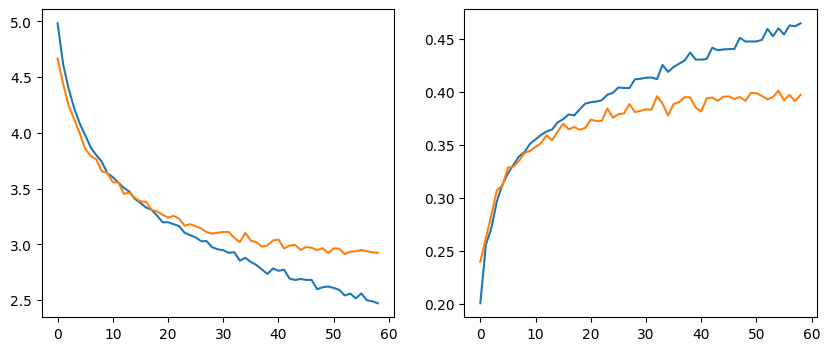

In [144]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')

plt.subplot(1, 2, 2)
plt.plot(hist.history['masked_accuracy'], label = 'masked_accuracy')
plt.plot(hist.history['val_masked_accuracy'], label = 'val_masked_accuracy')
plt.show()

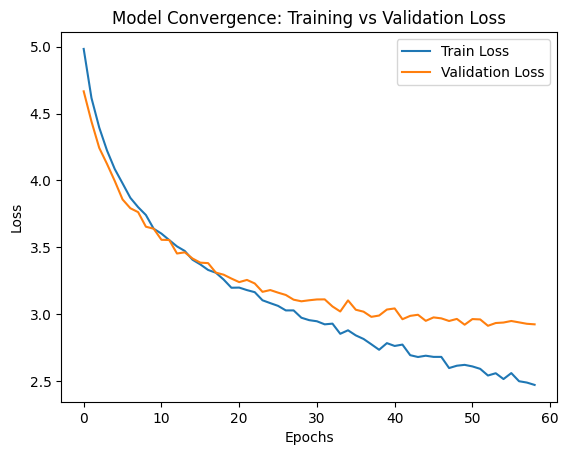

In [179]:
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Convergence: Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Loading and Testing on Test Data

In [ ]:
# Extract images from the test dataset (ignoring captions)
img_only_ds = ds_test.map(lambda img, cap: img)  # Map only the images (ignoring captions)

# Retrieve all images from the dataset
img = list(img_only_ds.as_numpy_iterator())  # Convert to a list of images


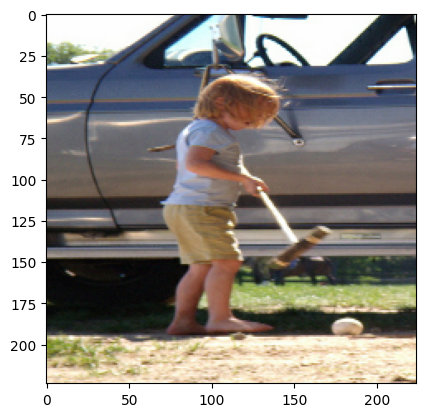

Generated Caption: a woman in a white shirt and shorts walks on a road


In [146]:
img = load_img(img_path[1].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

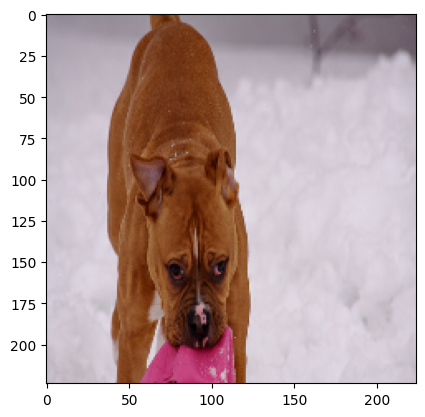

Generated Caption: a brown dog is running through the snow


In [147]:
img = load_img(img_path[2].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

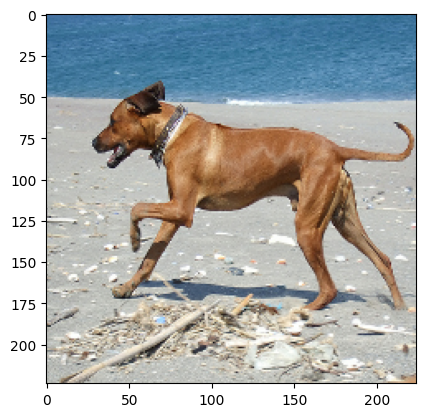

Generated Caption: a brown dog is running along a beach


In [148]:
img = load_img(img_path[3].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

# Evaluation of Catptions using BLEU score

In [196]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
def calculate_bleu_score(predicted_caption, reference_captions):
    """
    Calculate the BLEU score for a single predicted caption and multiple references.
    Args:
    - predicted_caption (str): Generated caption from the model.
    - reference_captions (list of str): List of reference captions.

    Returns:
    - float: BLEU score.
    """
    predicted_tokens = predicted_caption.split()
    reference_tokens = [ref.split() for ref in reference_captions]

    smooth_fn = SmoothingFunction().method1
    bleu = sentence_bleu(reference_tokens, predicted_tokens, smoothing_function=smooth_fn)

    return bleu

def calculate_highest_bleu_score(predicted_caption, reference_captions):
    """
    Calculate the highest BLEU score for a single predicted caption against multiple references.
    Args:
    - predicted_caption (str): Generated caption from the model.
    - reference_captions (list of str): List of reference captions.

    Returns:
    - float: Highest BLEU score.
    """
    highest_bleu = 0
    for ref_caption in reference_captions:
        # Calculate BLEU for each reference
        bleu = calculate_bleu_score(predicted_caption, [ref_caption])
        highest_bleu = max(highest_bleu, bleu)
    return highest_bleu

In [201]:
start_index = 20
num_examples = 3

bleu_scores = []

for img_path, reference_captions in train_raw.skip(start_index).take(num_examples):
    # Decode the image path and load the image
    img = load_img(img_path.numpy().decode('utf-8'))

    # Generate the caption using the model
    generated_caption = captioner_model.generate_text(img[tf.newaxis, ...])

    # Convert reference captions from Tensor to a list of strings
    reference_captions = [cap.numpy().decode('utf-8') for cap in reference_captions]

    # Calculate the highest BLEU score for this generated caption
    highest_bleu = calculate_highest_bleu_score(generated_caption, reference_captions)
    print(f"Generated Caption: {generated_caption}")
    print(f"Reference Captions: {reference_captions}")
    print(f"Highest BLEU Score: {highest_bleu:.2f}\n")

    # Append the highest BLEU score for this image
    bleu_scores.append(highest_bleu)

# Calculate the average of the highest BLEU scores
avg_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average Highest BLEU Score: {avg_bleu:.2f}")



Generated Caption: a young woman in a red shirt is walking down the street
Reference Captions: ['a boy in a red shirt , in front of a long blue wall , raises his eyebrow at the camera', 'A boy in a red shirt with stripes standing near a blue , brick wall with handicap signs .', 'An African American boy stands in front of a blue building in the handicapped space .', 'The boy in the orange shirt looks backwards .', 'The boy in the red shirt is next to a blue wall .']
Highest BLEU Score: 0.38

Generated Caption: a dog is running in the sand with a ball on the beach
Reference Captions: ['A brown dog is carrying a wet stick on the shore of the ocean .', 'A dog bounds across the sandy beach with a stick in his mouth and water splashing off his paws .', 'A wet , blond dog carries a stick on the shore .', 'The dog is running along the beach next to the ocean with a stick in its mouth .', 'The wet , brown dog has a stick in his mouth and is running in the sand next to the water .']
Highest BLEU

#Visualising Attention

In [160]:
@Captioner.add_method
def show_attention(self, img, temperature = 0.5):
    gen_text = self.generate_text(img = img[tf.newaxis, ...], temperature = temperature)
    cap_gen_tokens = cap_gen.split() + ['[END]']
    # Here we are adding [END] token as while printing text using id_to_text, it filters out [END] token even though it is generated.
    attn_scores = captioner_model.decoder.last_attention_scores
    attn_maps = einops.reduce(attn_scores, 'b num_heads seq_len (h w) -> seq_len h w', h = 7, w = 7, reduction = 'mean')

    len_result = len(attn_maps)
    col_len = int(np.ceil(len_result/2))
    row_len = 2

    for i in range(len_result-1):
        ax = plt.subplot(row_len, col_len, i+1)
        img_plot = ax.imshow(img/255)
        plt.title(cap_gen_tokens[i])
        ax.imshow(attn_maps[i], cmap = 'gray', alpha = 0.6, extent = img_plot.get_extent(), clim = [0, np.max(attn_maps[i])])
        plt.axis('off')

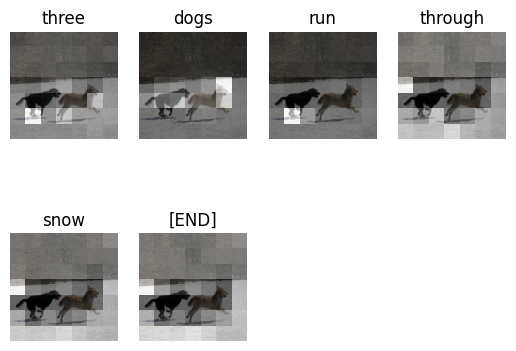

In [161]:
captioner_model.show_attention(img)

In [169]:
# Save the entire model (architecture + weights)
captioner_model.save('path_to_save_model/captioner_model.h5')
